In [2]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd


def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

### Random metrics experiments

In [3]:
BASE_LOG='tensorboard_logs/random'

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
# --- GLOBAL COLOR CYCLE SETUP ---
plt.rcParams['axes.prop_cycle'] = cycler(
    color=[
        "#1f77b4",  # blue
        "#ff7f0e",  # orange
        "#2ca02c",  # green
        "#d62728",  # red
        "#9467bd",  # purple
        "#8c564b",  # brown
        "#e377c2",  # pink
        "#7f7f7f",  # gray
        "#bcbd22",  # olive
        "#17becf",  # cyan
    ]
)


SPAN=20


def to_df(parsed, tag):
    """Normalize parse_tensorboard() output to a DataFrame with ['step','value']"""
    if isinstance(parsed, pd.DataFrame):
        df = parsed.copy()
        if "tag" in df.columns:
            df = df[df["tag"] == tag]
    elif isinstance(parsed, dict):
        df = parsed[tag].copy()
    else:
        raise TypeError("Unsupported parse_tensorboard output type.")
    if not {"step", "value"}.issubset(df.columns):
        raise ValueError("Expected columns 'step' and 'value' in parsed TF data.")
    return df[["step", "value"]].sort_values("step").reset_index(drop=True)

def step_spacing(df):
    """Robust default step gap for offsetting."""
    gap = df["step"].diff().median()
    if pd.isna(gap) or gap <= 0:
        gap = 1
    return int(gap)

def join_chain(run_dfs):
    """
    Given a list of DataFrames for a chain [df1, df2, ...] (already ordered),
    offset subsequent runs so they continue after the previous.
    Returns concatenated df with ['global_step','value'].
    """
    out = []
    offset = 0
    prev_gap = None

    for i, df in enumerate(run_dfs):
        df = df.copy()
        if i == 0:
            df["global_step"] = df["step"]
            prev_gap = step_spacing(df)
            offset = int(df["global_step"].max()) + prev_gap
        else:
            df["global_step"] = df["step"] + offset
            # keep previous spacing to avoid gaps
            prev_gap = prev_gap if prev_gap is not None else step_spacing(df)
            offset = int(df["global_step"].max()) + prev_gap
        out.append(df[["global_step", "value"]])

    return pd.concat(out, ignore_index=True)

def split_into_chains(models_dict):
    """
    Group model names into chains by a suffix pattern *_N (N >= 2).
    Name without numeric suffix = N=1. Returns dict: base -> [name ordered by N].
    """
    pat = re.compile(r"^(.*?)(?:_(\d+))?$")
    registry = {}  # base -> list of (n, name)

    for name in models_dict:
        m = pat.match(name)
        base = m.group(1) if m else name
        n = int(m.group(2)) if (m and m.group(2)) else 1
        registry.setdefault(base, []).append((n, name))

    chains = {base: [nm for n, nm in sorted(entries, key=lambda x: x[0])]
              for base, entries in registry.items()}
    return chains

def smooth_ema(df, span=SPAN):
    """EMA smoothing of 'value' over 'global_step'."""
    d = df.sort_values("global_step").copy()
    d["smooth"] = d["value"].ewm(span=span, adjust=False).mean()
    return d

# ---- main ----
def plot_all(models, TAG, SPAN, xlabel="", ylabel="", title=""):
    chains = split_into_chains(models)

    all_joined = []          # raw concatenated data
    all_joined_smooth = []   # with EMA smoothing

    #plt.figure()
    plt.figure(figsize=(14, 6))  


    for base, names in chains.items():
        # convert each run to df
        run_dfs = []
        for nm in names:
            try:
                run_dfs.append(to_df(models[nm], TAG))
            except Exception as e:
                print(f"Skipping {nm} due to error: {e}")
        if not run_dfs:
            continue

        joined = join_chain(run_dfs)
        joined["chain"] = base
        all_joined.append(joined)

        # Smooth and plot
        sm = smooth_ema(joined, span=SPAN)
        sm["chain"] = base
        all_joined_smooth.append(sm)

        # Optional: faint raw curve in the background
        #plt.plot(joined["global_step"], joined["value"], alpha=0.12, linewidth=1)

        # Smoothed curve
        plt.plot(sm["global_step"], sm["smooth"], label=base)

    # Combine to single DataFrames
    all_joined = pd.concat(all_joined, ignore_index=True) if all_joined else pd.DataFrame()
    all_joined_smooth = pd.concat(all_joined_smooth, ignore_index=True) if all_joined_smooth else pd.DataFrame()

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    #plt.ylim(-0.2, 1)   # y-axis cap
    if "nagroda za epizod" in title:
        plt.xlim(0,450000)
        
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.show()



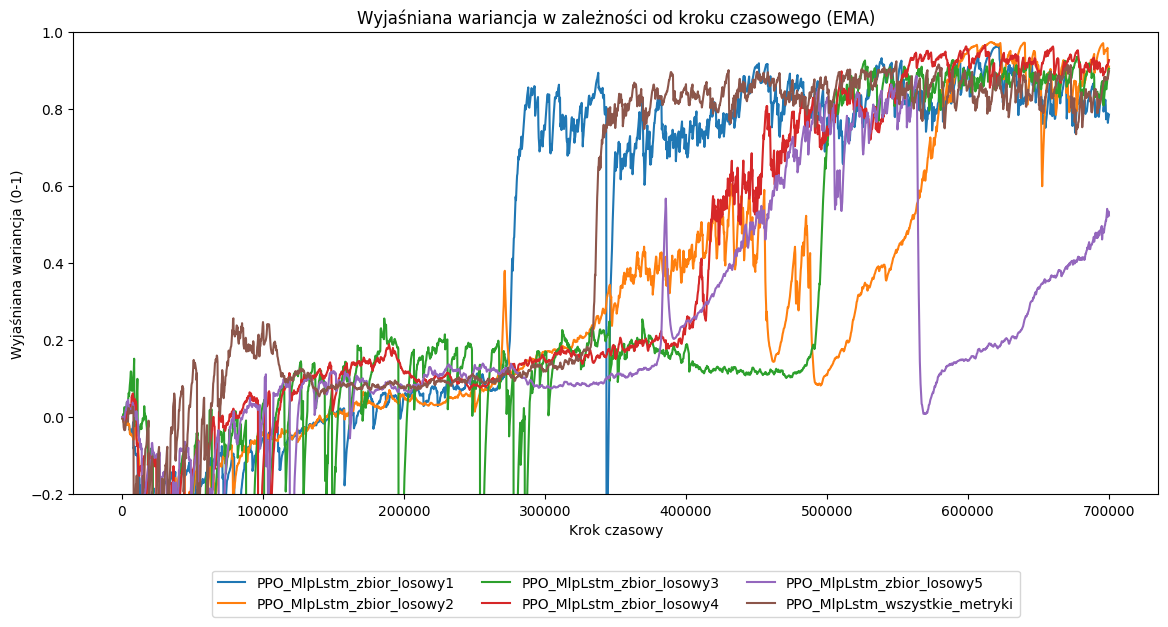

In [ ]:
TAG = "train/explained_variance"

models = {
    'PPO_MlpLstm_zbior_losowy1':   parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_62', scalars=[TAG]),
    'PPO_MlpLstm_zbior_losowy2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_48', scalars=[TAG]),
    'PPO_MlpLstm_zbior_losowy3': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_50', scalars=[TAG]),
    'PPO_MlpLstm_zbior_losowy4': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_58', scalars=[TAG]),
    'PPO_MlpLstm_zbior_losowy5': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_64', scalars=[TAG]),
    'PPO_MlpLstm_wszystkie_metryki': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_60', scalars=[TAG]),
}


SPAN = 20
xlabel="Krok czasowy"
ylabel="Wyjaśniana wariancja (0-1)"
title="Wyjaśniana wariancja w zależności od kroku czasowego (EMA)"
plot_all(models, TAG, SPAN, xlabel=xlabel, ylabel=ylabel, title=title)

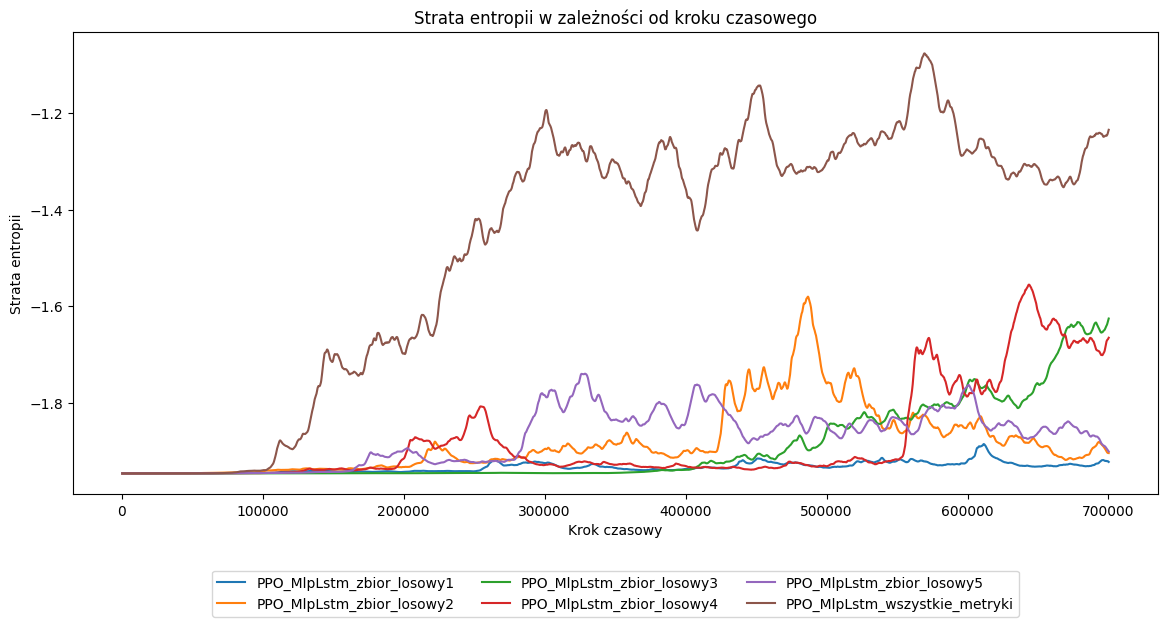

In [10]:
TAG = "train/entropy_loss"
xlabel="Krok czasowy"
ylabel="Strata entropii"
title="Strata entropii w zależności od kroku czasowego"
models = {
    'PPO_MlpLstm_zbior_losowy1':   parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_62', scalars=[TAG]),
    'PPO_MlpLstm_zbior_losowy2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_48', scalars=[TAG]),
    'PPO_MlpLstm_zbior_losowy3': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_50', scalars=[TAG]),
    'PPO_MlpLstm_zbior_losowy4': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_58', scalars=[TAG]),
    'PPO_MlpLstm_zbior_losowy5': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_64', scalars=[TAG]),
    'PPO_MlpLstm_wszystkie_metryki': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_60', scalars=[TAG]),
}
plot_all(models, TAG, SPAN, xlabel=xlabel, ylabel=ylabel, title=title)


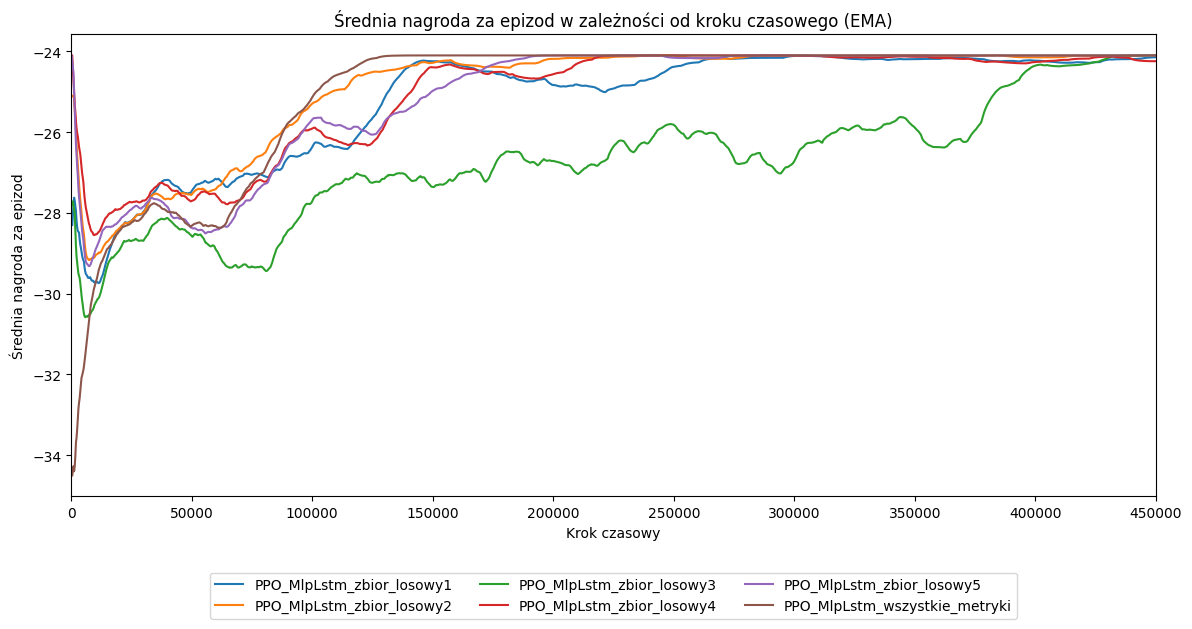

In [12]:
TAG = "rollout/ep_rew_mean"
models = {
    'PPO_MlpLstm_zbior_losowy1':   parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_62', scalars=[TAG]),
    'PPO_MlpLstm_zbior_losowy2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_48', scalars=[TAG]),
    'PPO_MlpLstm_zbior_losowy3': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_50', scalars=[TAG]),
    'PPO_MlpLstm_zbior_losowy4': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_58', scalars=[TAG]),
    'PPO_MlpLstm_zbior_losowy5': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_64', scalars=[TAG]),
    'PPO_MlpLstm_wszystkie_metryki': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_60', scalars=[TAG]),
}
xlabel="Krok czasowy"
ylabel="Średnia nagroda za epizod"
title="Średnia nagroda za epizod w zależności od kroku czasowego (EMA)"
plot_all(models, TAG, SPAN, xlabel=xlabel, ylabel=ylabel, title=title)


### Ręczny wybór metryk

In [5]:
BASE_LOG="tensorboard_logs/manual"

In [21]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
SPAN = 1





def to_df(parsed, tag):
    """Normalize parse_tensorboard() output to a DataFrame with ['step','value']"""
    if isinstance(parsed, pd.DataFrame):
        df = parsed.copy()
        if "tag" in df.columns:
            df = df[df["tag"] == tag]
    elif isinstance(parsed, dict):
        df = parsed[tag].copy()
    else:
        raise TypeError("Unsupported parse_tensorboard output type.")
    if not {"step", "value"}.issubset(df.columns):
        raise ValueError("Expected columns 'step' and 'value' in parsed TF data.")
    return df[["step", "value"]].sort_values("step").reset_index(drop=True)

def step_spacing(df):
    """Robust default step gap for offsetting."""
    gap = df["step"].diff().median()
    if pd.isna(gap) or gap <= 0:
        gap = 1
    return int(gap)

def join_chain(run_dfs):
    """
    Given a list of DataFrames for a chain [df1, df2, ...] (already ordered),
    offset subsequent runs so they continue after the previous.
    Returns concatenated df with ['global_step','value'].
    """
    out = []
    offset = 0
    prev_gap = None

    for i, df in enumerate(run_dfs):
        df = df.copy()
        if i == 0:
            df["global_step"] = df["step"]
            prev_gap = step_spacing(df)
            offset = int(df["global_step"].max()) + prev_gap
        else:
            df["global_step"] = df["step"] + offset
            # keep previous spacing to avoid gaps
            prev_gap = prev_gap if prev_gap is not None else step_spacing(df)
            offset = int(df["global_step"].max()) + prev_gap
        out.append(df[["global_step", "value"]])

    return pd.concat(out, ignore_index=True)

def split_into_chains(models_dict):
    """
    Group model names into chains by a suffix pattern *_N (N >= 2).
    Name without numeric suffix = N=1. Returns dict: base -> [name ordered by N].
    """
    pat = re.compile(r"^(.*?)(?:_(\d+))?$")
    registry = {}  # base -> list of (n, name)

    for name in models_dict:
        m = pat.match(name)
        base = m.group(1) if m else name
        n = int(m.group(2)) if (m and m.group(2)) else 1
        registry.setdefault(base, []).append((n, name))

    chains = {base: [nm for n, nm in sorted(entries, key=lambda x: x[0])]
              for base, entries in registry.items()}
    return chains

def smooth_ema(df, span=SPAN):
    """EMA smoothing of 'value' over 'global_step'."""
    d = df.sort_values("global_step").copy()
    d["smooth"] = d["value"].ewm(span=span, adjust=False).mean()
    return d


def plot_all(models, TAG, SPAN, xlabel="", ylabel="", title=""):
    chains = split_into_chains(models)

    all_joined = []        
    all_joined_smooth = []   


    plt.figure(figsize=(14, 6))  

    for base, names in chains.items():
        # convert each run to df
        run_dfs = []
        for nm in names:
            try:
                run_dfs.append(to_df(models[nm], TAG))
            except Exception as e:
                print(f"Skipping {nm} due to error: {e}")
        if not run_dfs:
            continue

        joined = join_chain(run_dfs)
        joined["chain"] = base
        all_joined.append(joined)
        sm = smooth_ema(joined, span=SPAN)
        sm["chain"] = base
        all_joined_smooth.append(sm)
        plt.plot(sm["global_step"], sm["smooth"], label=base, linewidth=1.5)

    # Combine to single DataFrames
    all_joined = pd.concat(all_joined, ignore_index=True) if all_joined else pd.DataFrame()
    all_joined_smooth = pd.concat(all_joined_smooth, ignore_index=True) if all_joined_smooth else pd.DataFrame()

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if "straty wartości" in title:
        plt.ylim(0, 0.015)   # y-axis cap
    if "nagroda" in title:
        plt.xlim(0,150000)
    if "wariancja" in title:
        plt.ylim(-0.1, 1.0)
    plt.legend()
    plt.show()




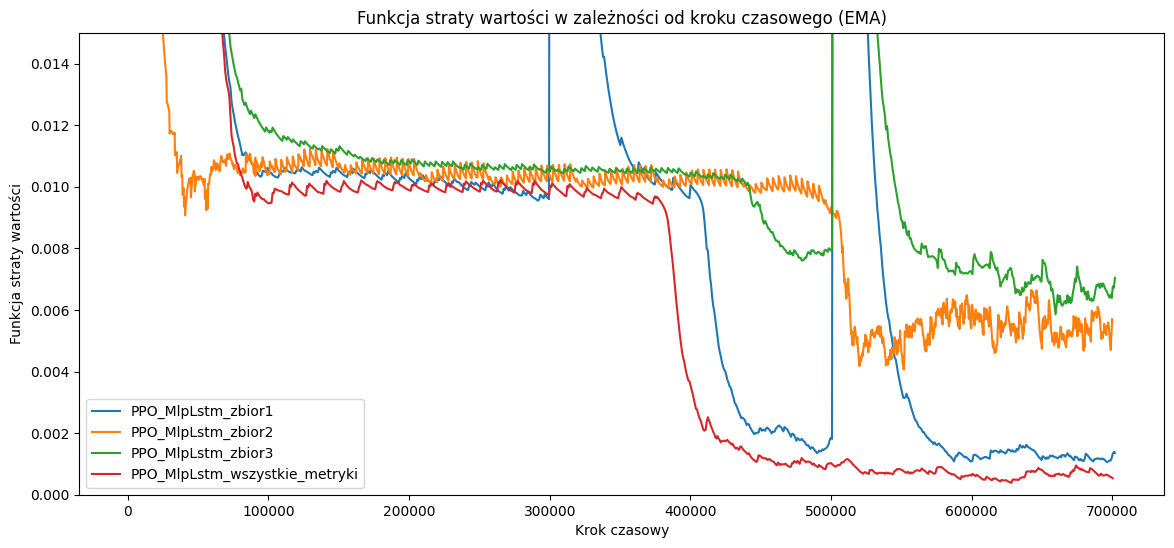

In [14]:
TAG = "train/value_loss"

models = {
    'PPO_MlpLstm_zbior1': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_14', scalars=[TAG]),
    'PPO_MlpLstm_zbior1_2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_16', scalars=[TAG]), # fragment drugi przebiegu uczenia dla zbioru 1
    'PPO_MlpLstm_zbior1_3': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_26', scalars=[TAG]), # fragment trzeci przebiegu uczenia dla zbioru 1
    'PPO_MlpLstm_zbior2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_91', scalars=[TAG]),
    'PPO_MlpLstm_zbior3':   parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_19', scalars=[TAG]),
    'PPO_MlpLstm_zbior3_2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_20', scalars=[TAG]),# fragment drugi przebiegu uczenia dla zbioru 3
    'PPO_MlpLstm_wszystkie_metryki': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_22', scalars=[TAG]),

}
xlabel="Krok czasowy"
ylabel="Funkcja straty wartości"
title="Funkcja straty wartości w zależności od kroku czasowego (EMA)"
plot_all(models, TAG, SPAN, xlabel=xlabel, ylabel=ylabel, title=title)


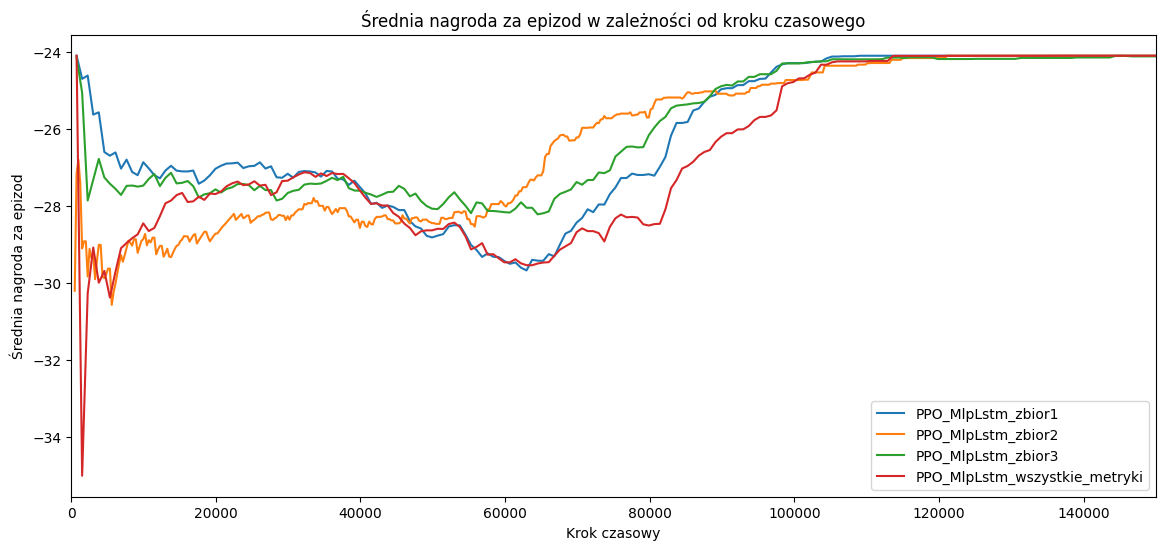

In [22]:

TAG = "rollout/ep_rew_mean"

models = {
    'PPO_MlpLstm_zbior1': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_14', scalars=[TAG]),
    'PPO_MlpLstm_zbior1_2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_16', scalars=[TAG]), # fragment drugi przebiegu uczenia dla zbioru 1
    'PPO_MlpLstm_zbior1_3': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_26', scalars=[TAG]), # fragment trzeci przebiegu uczenia dla zbioru 1
    'PPO_MlpLstm_zbior2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_91', scalars=[TAG]),
    'PPO_MlpLstm_zbior3':   parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_19', scalars=[TAG]),
    'PPO_MlpLstm_zbior3_2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_20', scalars=[TAG]),# fragment drugi przebiegu uczenia dla zbioru 3
    'PPO_MlpLstm_wszystkie_metryki': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_22', scalars=[TAG]),

}
xlabel="Krok czasowy"
ylabel="Średnia nagroda za epizod"
title="Średnia nagroda za epizod w zależności od kroku czasowego"
plot_all(models, TAG, SPAN, xlabel=xlabel, ylabel=ylabel, title=title)

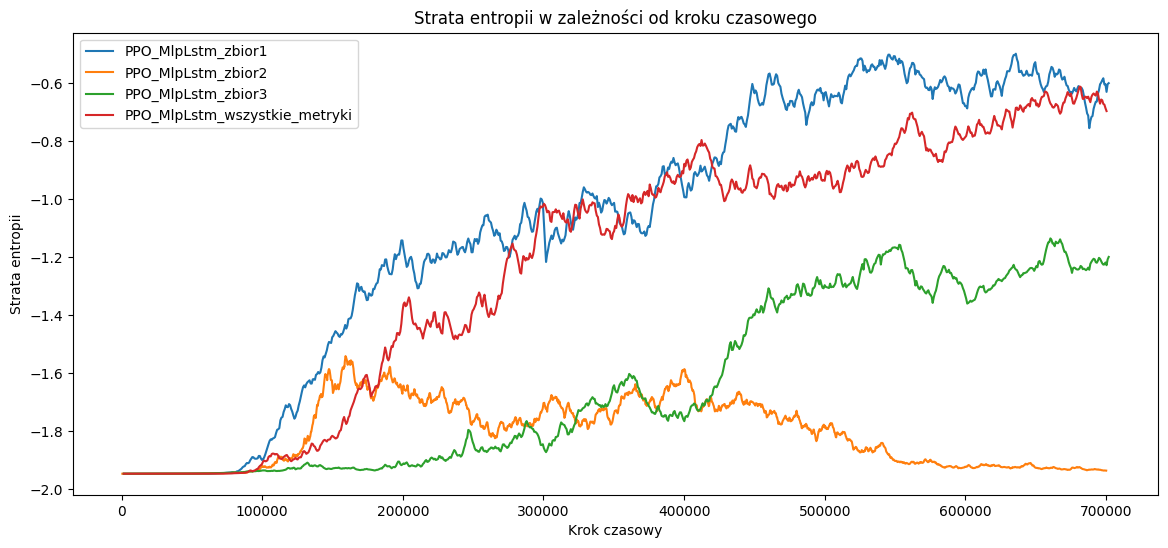

In [23]:
TAG="train/entropy_loss" 
models = {
    'PPO_MlpLstm_zbior1': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_14', scalars=[TAG]),
    'PPO_MlpLstm_zbior1_2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_16', scalars=[TAG]), # fragment drugi przebiegu uczenia dla zbioru 1
    'PPO_MlpLstm_zbior1_3': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_26', scalars=[TAG]), # fragment trzeci przebiegu uczenia dla zbioru 1
    'PPO_MlpLstm_zbior2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_91', scalars=[TAG]),
    'PPO_MlpLstm_zbior3':   parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_19', scalars=[TAG]),
    'PPO_MlpLstm_zbior3_2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_20', scalars=[TAG]),# fragment drugi przebiegu uczenia dla zbioru 3
    'PPO_MlpLstm_wszystkie_metryki': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_22', scalars=[TAG]),

}
xlabel="Krok czasowy"
ylabel="Strata entropii"
title="Strata entropii w zależności od kroku czasowego"
plot_all(models, TAG, SPAN, xlabel=xlabel, ylabel=ylabel, title=title)


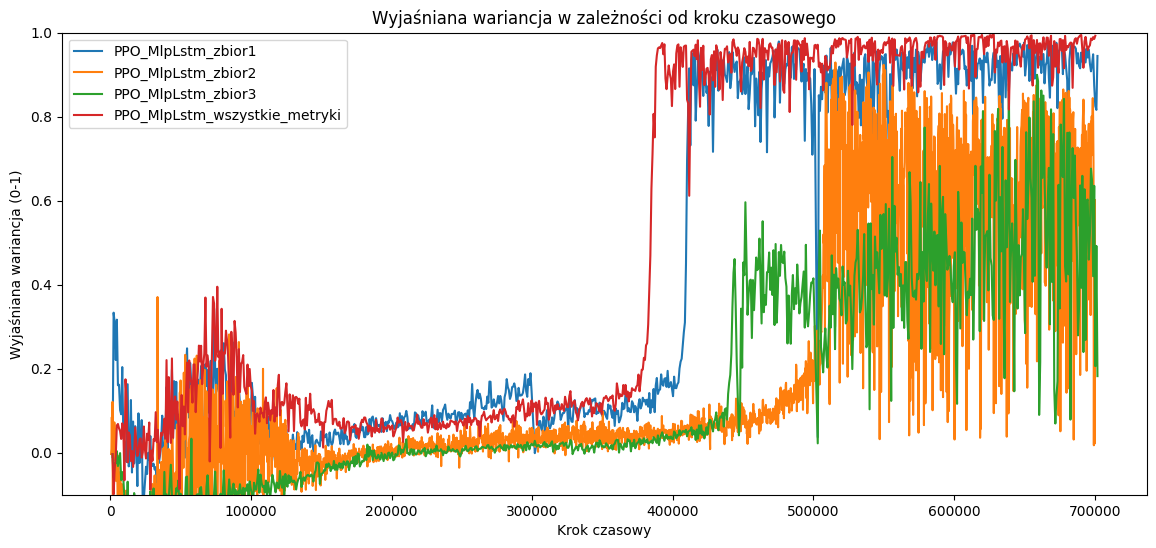

In [24]:
TAG="train/explained_variance" 
models = {
    'PPO_MlpLstm_zbior1': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_14', scalars=[TAG]),
    'PPO_MlpLstm_zbior1_2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_16', scalars=[TAG]), # fragment drugi przebiegu uczenia dla zbioru 1
    'PPO_MlpLstm_zbior1_3': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_26', scalars=[TAG]), # fragment trzeci przebiegu uczenia dla zbioru 1
    'PPO_MlpLstm_zbior2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_91', scalars=[TAG]),
    'PPO_MlpLstm_zbior3':   parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_19', scalars=[TAG]),
    'PPO_MlpLstm_zbior3_2': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_20', scalars=[TAG]),# fragment drugi przebiegu uczenia dla zbioru 3
    'PPO_MlpLstm_wszystkie_metryki': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_22', scalars=[TAG]),

}
xlabel="Krok czasowy"
ylabel="Wyjaśniana wariancja (0-1)"
title="Wyjaśniana wariancja w zależności od kroku czasowego"
plot_all(models, TAG, SPAN, xlabel=xlabel, ylabel=ylabel, title=title)


In [7]:
BASE_LOG="./output_malota/"

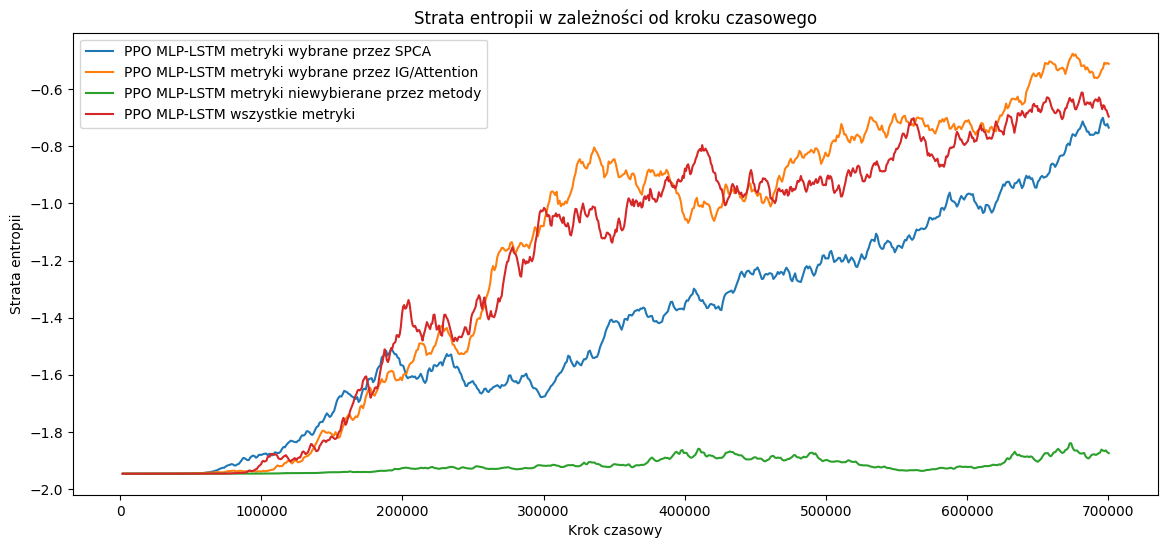

In [14]:
TAG="train/entropy_loss" 
models = {
    'PPO MLP-LSTM metryki wybrane przez SPCA': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_196', scalars=[TAG]),
    'PPO MLP-LSTM metryki wybrane przez IG/Attention': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_155', scalars=[TAG]),
    'PPO MLP-LSTM metryki niewybierane przez metody': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_156', scalars=[TAG]),
    'PPO MLP-LSTM wszystkie metryki': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_22', scalars=[TAG]),

}
xlabel="Krok czasowy"
ylabel="Strata entropii"
title="Strata entropii w zależności od kroku czasowego"
plot_all(models, TAG, SPAN, xlabel=xlabel, ylabel=ylabel, title=title)

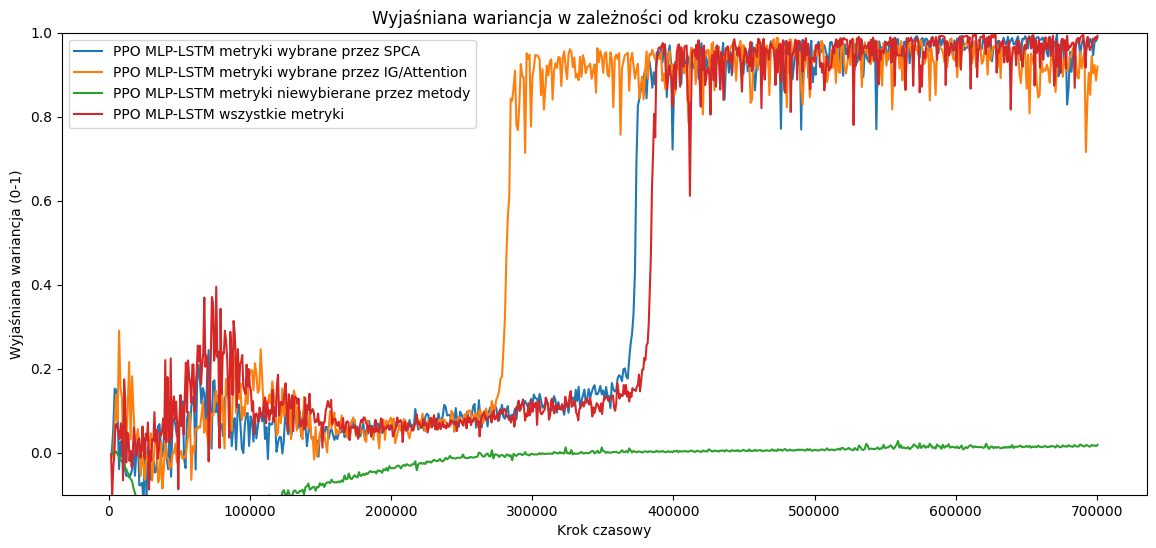

In [15]:
TAG="train/explained_variance" 
models = {
    'PPO MLP-LSTM metryki wybrane przez SPCA': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_196', scalars=[TAG]),
    'PPO MLP-LSTM metryki wybrane przez IG/Attention': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_155', scalars=[TAG]),
    'PPO MLP-LSTM metryki niewybierane przez metody': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_156', scalars=[TAG]),
    'PPO MLP-LSTM wszystkie metryki': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_22', scalars=[TAG]),

}
xlabel="Krok czasowy"
ylabel="Wyjaśniana wariancja (0-1)"
title="Wyjaśniana wariancja w zależności od kroku czasowego"
plot_all(models, TAG, SPAN, xlabel=xlabel, ylabel=ylabel, title=title)

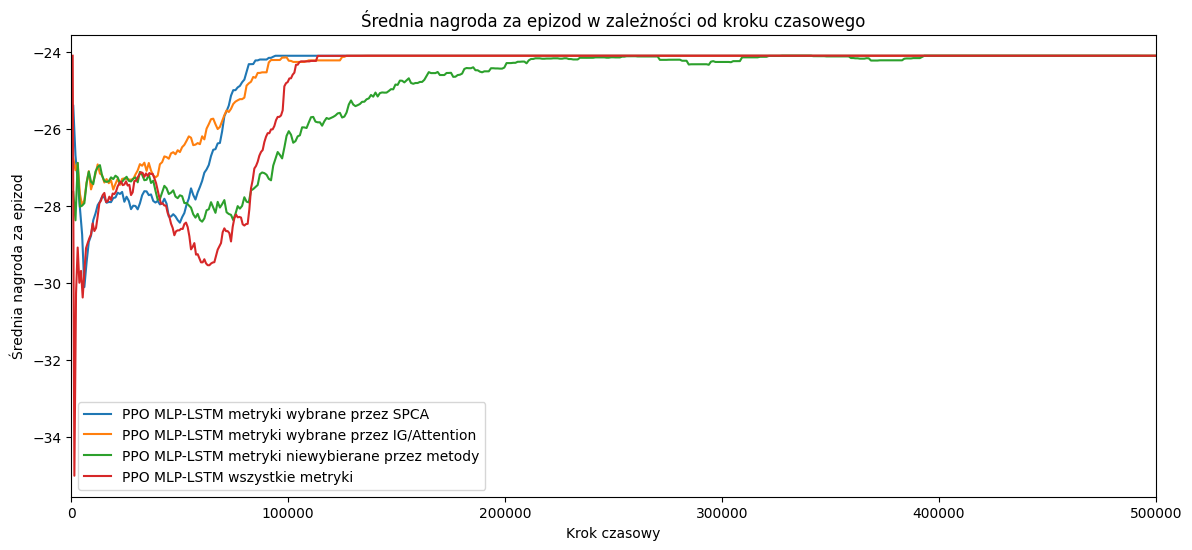

In [16]:

TAG = "rollout/ep_rew_mean"

models = {
    'PPO MLP-LSTM metryki wybrane przez SPCA': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_196', scalars=[TAG]),
    'PPO MLP-LSTM metryki wybrane przez IG/Attention': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_155', scalars=[TAG]),
    'PPO MLP-LSTM metryki niewybierane przez metody': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_156', scalars=[TAG]),
    'PPO MLP-LSTM wszystkie metryki': parse_tensorboard(path=f'./{BASE_LOG}/RecurrentPPO_22', scalars=[TAG]),

}
xlabel="Krok czasowy"
ylabel="Średnia nagroda za epizod"
title="Średnia nagroda za epizod w zależności od kroku czasowego"
plot_all(models, TAG, SPAN, xlabel=xlabel, ylabel=ylabel, title=title)